## Robson de Oliveira Caldas - 1831134018

## 1 - Banco de dados

### Conjunto de LOGs de um servidor Web Apache2.

O objetivo é classificar os acessos como reais (feitos por humanos) e fake (feitos por bots), a fim de bloquear os fakes e reduzir o tráfego desnecessário no servidor.

Bots, spiders e outros rastreadores que acessam as páginas dinâmicas podem causar uso extensivo de recursos (memória e CPU). Isso pode levar a uma alta carga no servidor e atrasar o site legítimo. Existem ainda os bots maliciosos, que vasculham o servidor em busca de vulnerabilidades constantemente.


#### Multiplos arquivos de log

Os logs são armazenados no servidor em arquivos separados, aqui vamos juntar todos em um só arquivo para o processamento:

In [1]:
# import lib.merge_logs as merge
# merge.merge('log/access.log')

## 2 - Pré-processamento

### Logs no arquivo 'access.log.all'. Criar um DataFrame Pandas:

In [2]:
"""
RCaldas Log Parser.
"""
import sys,os
import time
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
%matplotlib inline

try:
    log = open('log/access.log.all')
except IOError:
    print(__doc__,"\nErro ao ler o arquivo de log.")
    sys.exit(1)

### Dataframe
df = []
### Acumulador de palavras do campo Agent
tags_total = []
### Acumulador de IPs de bot
ipsbot = []
### Acumulador de IPs de humanos
ipshum = []
### Regex para pegar os campos corretos de cada linha
regc = re.compile('^(?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) .+'
                  ' \[(?P<time>[0-9]+/\S+:\d{2}:\d{2}:\d{2} .+)\] '
                  '\"(?P<met>\S+) (?P<urn>\S+) \S+\" (?P<code>\d+) '
                  '(?P<size>\d+) \"(?P<identd>[^\"]+)\" \"(?P<agent>[^\"]*)\"')

### Loop em cada linha do arquivo:
for line in log:
    try:
        ### Armazenar os dados capturados com o regex (IP, URN, Código HTTP, Tamanho):
        m = regc.match(line)
        ip, urn, code, size = m.group('ip', 'urn', 'code', 'size')
        
        ### Converter data e hora para formato datetime
        time = datetime.datetime.strptime(m.group('time'), '%d/%b/%Y:%H:%M:%S %z')
        
        ### Método já categorizado = GET: 0, POST: 1, OUTRO: 2
        if m.group('met') == 'GET': metodo = 0
        elif m.group('met') == 'POST': metodo = 1
        else: metodo = 2
        
        ### Tem algo no identd?
        if m.group('identd') == '-': identd = 0
        else: identd = 1
        
        ### Informaçoes do agente acumulando em 'tags_total'
        agent = m.group('agent')
        tags = []
        for i in agent.split():
            i = i.split('/')[0]
            i = i.strip(';/)(.,')
            tags.append(i)
            tags_total.append(i)

    except:
        ### print('Linha fora do padrão:\n', line)
        continue
        
    ### Alimentar o dataframe com os dados:
    df.append({'IP': ip, 'Data': time, 'Metodo': metodo, 'Request': urn, 
               'Code': code, 'Bytes': size, 'Identd': identd, 'Agent': agent})
log.close()
df = pd.DataFrame(df)

### Converter as colunas numéricas em inteiro:
df['Bytes'] = pd.to_numeric(df['Bytes'])
df['Code'] = pd.to_numeric(df['Code'])
### Preencher as colunas Bot e Humano
df['Bot'] = 0
df['Hum'] = 0

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17578 entries, 0 to 17577
Data columns (total 10 columns):
Agent      17578 non-null object
Bytes      17578 non-null int64
Code       17578 non-null int64
Data       17578 non-null datetime64[ns, UTC-03:00]
IP         17578 non-null object
Identd     17578 non-null int64
Metodo     17578 non-null int64
Request    17578 non-null object
Bot        17578 non-null int64
Hum        17578 non-null int64
dtypes: datetime64[ns, UTC-03:00](1), int64(6), object(3)
memory usage: 1.3+ MB


**Descrição das variáveis:**

- Agent   : informações do agente (browser) como versão, compatibilidades, sistema operacional...
- Bytes   : Tamanho em bytes da requisição
- Code    : Código HTTP recebido (200: OK, 404: Not Found, 301: Redirect ...)
- Data    : Data e hora do acesso
- IP      : IP do cliente
- Identd  : Campo de identificação, presente geralmente em acessos já iniciados, não no primeiro GET.
- Metodo  : Metodo da requisição (GET: 0, POST:1, OUTROS:2)
- Request : URN solicitado para o servidor (Ex: /wp-admin.php)

In [3]:
df.head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum
0,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-27 00:08:19-03:00,209.239.118.173,0,0,/wp-login.php,0,0
1,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-27 00:08:20-03:00,209.239.118.173,0,1,/wp-login.php,0,0
2,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-27 00:08:20-03:00,209.239.118.173,0,1,/xmlrpc.php,0,0
3,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,558,301,2019-03-27 00:12:11-03:00,27.133.137.100,0,0,/wp.rar,0,0
4,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3587,404,2019-03-27 00:12:12-03:00,27.133.137.100,1,0,/wp.rar,0,0


## 3 - Análise da Distribuição

### * Bytes e Request

#### Os bytes são maiores quando o campo Identd existe.
#### Requests grandes sem identd tem mais chances de ser bot.

In [4]:
### Cria uma coluna com o tamanho do Request para comparar com os Bytes
req_Len = []
for i in df.Request.apply(len):
    req_Len.append(i)
df['rLen'] = req_Len

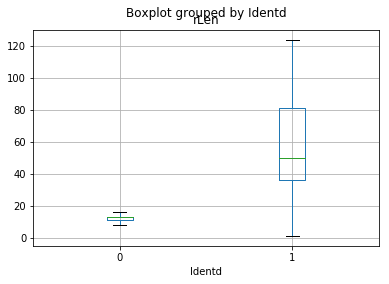

In [5]:
### Tamanho do Request por Identd, excluindo os outliers
df.boxplot(column='rLen', by = 'Identd', showfliers=False)

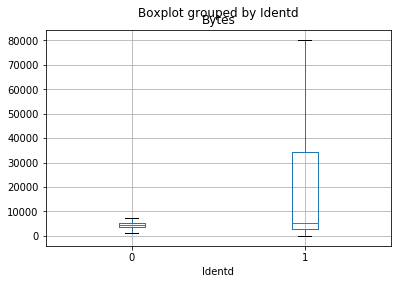

In [6]:
## Tamanho da requisição por Identd, excluindo os outliers
df.boxplot(column='Bytes', by = 'Identd', showfliers=False)

In [7]:
### Exibir os valores para comparar
df[['rLen','Bytes']].tail(10)

,rLen,Bytes
17568,69,5750
17569,36,22681
17570,55,18837
17571,55,19494
17572,74,6699
17573,1,27934
17574,37,68080
17575,69,6442
17576,64,246126
17577,74,6195


In [8]:
### Ver percentil dos requests
df['rLen'].describe()

count    17578.000000
mean        42.545853
std         36.540780
min          1.000000
25%         13.000000
50%         36.000000
75%         65.000000
max        534.000000
Name: rLen, dtype: float64

In [9]:
## Analisar os registros com Request maiores que 63 (75%) que não tenham Identd
df[(df['rLen']>=63) & (df['Identd']==0)].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
2003,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:26-03:00,115.68.182.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...,0,0,83
2005,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:28-03:00,115.68.182.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...,0,0,83
2007,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:31-03:00,115.68.182.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...,0,0,83
2009,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,714,301,2019-03-26 18:19:34-03:00,115.68.182.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...,0,0,83
2011,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,714,301,2019-03-26 18:19:37-03:00,115.68.182.152,0,1,/wp-admin/admin-post.php?swp_debug=load_option...,0,0,83
2013,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,714,301,2019-03-26 18:19:39-03:00,115.68.182.152,0,1,/wp-admin/admin-ajax.php?swp_debug=load_option...,0,0,83
2194,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3456,200,2019-03-26 21:06:12-03:00,107.191.108.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...,0,0,83
2195,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3294,400,2019-03-26 21:06:13-03:00,107.191.108.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...,0,0,83
2196,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3456,200,2019-03-26 21:06:13-03:00,107.191.108.152,0,0,/wp-admin/admin-post.php?swp_debug=load_option...,0,0,83
2197,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,3294,400,2019-03-26 21:06:14-03:00,107.191.108.152,0,0,/wp-admin/admin-ajax.php?swp_debug=load_option...,0,0,83


In [10]:
### Ver percentil dos Bytes
df['Bytes'].describe()

count    1.757800e+04
mean     1.783226e+04
std      4.662834e+04
min      0.000000e+00
25%      3.053000e+03
50%      4.752000e+03
75%      1.308900e+04
max      2.037909e+06
Name: Bytes, dtype: float64

In [11]:
### Analisar os registros com Request maiores que percentil de 75% que não tenham Identd
df[(df['Bytes']>=12645) & (df['Identd']==0)].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
71,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,198842,200,2019-03-27 00:38:33-03:00,144.76.3.79,0,0,/,0,0,1
74,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,202125,200,2019-03-27 00:38:40-03:00,144.76.3.79,0,0,/,0,0,1
175,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,31302,200,2019-03-27 02:35:44-03:00,38.130.172.26,0,0,/,0,0,1
216,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:5...,31140,200,2019-03-27 03:28:26-03:00,198.199.92.66,0,0,/,0,0,1
354,-,202144,200,2019-03-27 03:28:41-03:00,35.230.58.15,0,0,/,0,0,1
380,Wget/1.13.4 (linux-gnu),202148,200,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
381,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,202148,200,2019-03-27 04:32:32-03:00,93.119.227.34,0,0,/,0,0,1
745,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,31120,200,2019-03-27 10:06:29-03:00,66.249.66.15,0,0,/,0,0,1
746,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,31126,200,2019-03-27 10:06:30-03:00,66.249.66.70,0,0,/,0,0,1
772,Go-http-client/1.1,30891,200,2019-03-27 10:35:17-03:00,34.220.154.37,0,0,/,0,0,1


#### Marcar IPs com agents estranhos como o seguinte:

In [12]:
df.iloc[16070]

Agent                                         }__test|O:21:\
Bytes                                                   4179
Code                                                     200
Data                               2019-04-03 03:57:43-03:00
IP                                              94.23.255.34
Identd                                                     0
Metodo                                                     0
Request    /?1=%40ini_set%28%22display_errors%22%2C%220%2...
Bot                                                        0
Hum                                                        0
rLen                                                     311
Name: 16070, dtype: object

In [13]:
### Ver os registros desse IP
df[df['IP']=="94.23.255.34"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
16065,}__test|O:21:\,4179,200,2019-04-03 03:46:16-03:00,94.23.255.34,0,0,/?1=%40ini_set%28%22display_errors%22%2C%220%2...,0,0,311
16066,Python-urllib/2.7,4179,200,2019-04-03 03:46:18-03:00,94.23.255.34,0,0,/?1=%40ini_set%28%22display_errors%22%2C%220%2...,0,0,311
16067,}__test|O:21:\,3892,404,2019-04-03 03:46:26-03:00,94.23.255.34,0,0,//administrator/?1=%40ini_set%28%22display_err...,0,0,326
16068,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3947,404,2019-04-03 03:46:31-03:00,94.23.255.34,1,0,//administrator//webconfig.txt.php,0,0,34
16070,}__test|O:21:\,4179,200,2019-04-03 03:57:43-03:00,94.23.255.34,0,0,/?1=%40ini_set%28%22display_errors%22%2C%220%2...,0,0,311


In [14]:
### Guardar esse IP como bot
ipsbot.append('94.23.255.34')

In [15]:
### Bot com bytes altos e rLen pequeno
ipsbot.append('93.119.227.34')
df[df['IP']=="93.119.227.34"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
377,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,0,0,1
378,Mozilla/5.0 (Linux; Android 7.0; SM-G930V Buil...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,0,0,1
379,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3537,301,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
380,Wget/1.13.4 (linux-gnu),202148,200,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
381,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,202148,200,2019-03-27 04:32:32-03:00,93.119.227.34,0,0,/,0,0,1


In [16]:
### Bot
ipsbot.append('54.149.94.16')
df[df['IP']=="54.149.94.16"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
16848,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,582,301,2019-04-02 23:09:04-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
16849,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,594,301,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
16850,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,3824,404,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
16851,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,3820,404,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
16852,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,574,301,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/,0,0,1


In [17]:
### Bot
ipsbot.append('13.53.136.118')
df[df['IP']=="13.53.136.118"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
16865,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,236,301,2019-04-03 00:00:44-03:00,13.53.136.118,0,2,/,0,0,1
16866,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,3632,200,2019-04-03 00:00:44-03:00,13.53.136.118,0,2,/,0,0,1
16867,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,581,404,2019-04-03 00:00:44-03:00,13.53.136.118,0,0,/robots.txt,0,0,11
16868,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,3984,200,2019-04-03 00:00:45-03:00,13.53.136.118,0,0,/,0,0,1


In [18]:
### Bot
ipsbot.append('103.129.220.250')
ipsbot.append('138.197.68.2')
ipsbot.append('104.131.6.66')
df[df['IP']=="104.131.6.66"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
14301,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-19 22:27:13-03:00,104.131.6.66,0,0,/wp-login.php,0,0,13
14302,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-19 22:27:18-03:00,104.131.6.66,0,1,/wp-login.php,0,0,13
14303,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-19 22:27:18-03:00,104.131.6.66,0,0,/wp-login.php,0,0,13
14304,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5117,200,2019-03-19 22:27:19-03:00,104.131.6.66,0,1,/wp-login.php,0,0,13
14305,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-19 22:27:19-03:00,104.131.6.66,0,1,/xmlrpc.php,0,0,11


### * Code
####  Muitos GETs retornando 404 significa algum bot fazendo varredura por bruteforce.

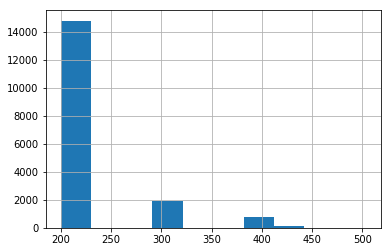

In [19]:
df['Code'].hist()

In [20]:
df['Code'].value_counts()

200    14797
301     1931
404      593
400      145
421       93
302        6
500        4
206        3
503        2
405        2
304        2
Name: Code, dtype: int64

### * Agent
#### Analisar os Agents mais comuns

In [21]:
### Gerar a lista dos nomes mais usadas no campo 'Agent':
tagsorted = sorted([(value, key) for (key,value) in Counter(tags_total).items()], reverse=True)

topagents = [x[1] for x in tagsorted[:11]]
for top in topagents: print(top)

Mozilla
Gecko
Windows
NT
like
KHTML
AppleWebKit
Safari
Linux
Firefox
Chrome


In [22]:
## Analisar os logs pelo campo 'Agent'
df.loc[(df['Agent'].str.contains('Mozilla')==False) & 
       (df['Agent'].str.contains('http')==False)  & 
       (df['Agent'].str.contains('Wget')==False),
       ['Agent','Request','IP']].head(10)

,Agent,Request,IP
14,Poster,/xmlrpc.php,198.71.241.16
354,-,/,35.230.58.15
382,Windows Live Writter,/xmlrpc.php,192.145.239.28
738,WordPress,/xmlrpc.php,67.225.140.17
988,-,/cms/,120.35.38.102
1080,Poster,/xmlrpc.php,89.252.186.201
1162,Poster,/xmlrpc.php,37.9.169.9
1235,Poster,/xmlrpc.php,47.93.59.218
1920,Windows Live Writter,/xmlrpc.php,184.168.200.88
2160,WordPress,/xmlrpc.php,89.46.106.218


In [23]:
### Bot
ipsbot.append('91.230.25.106')
df[df['IP']=="91.230.25.106"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
16006,Mozilla/5.0 (X11; Linux x86_64; rv:3.4) Goanna...,583,301,2019-03-18 15:50:43-03:00,91.230.25.106,1,0,/,0,0,1
16008,Mozilla/5.0 (X11; Linux x86_64; rv:3.4) Goanna...,31133,200,2019-03-18 15:50:44-03:00,91.230.25.106,0,0,/,0,0,1
16009,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,496,302,2019-03-18 15:50:46-03:00,91.230.25.106,1,0,/wp-login.php?action=register,0,0,29
16010,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,1756,200,2019-03-18 15:50:46-03:00,91.230.25.106,1,0,/wp-login.php?registration=disabled,0,0,35


In [24]:
### Bot
ipsbot.append('80.84.57.96')
ipsbot.append('80.84.57.101')
ipsbot.append('80.84.57.93')
df[df['IP'].str.contains("80.84.57")].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
2530,-,3334,301,2019-03-17 07:05:37-03:00,80.84.57.101,0,0,/,0,0,1
2531,-,201946,200,2019-03-17 07:05:37-03:00,80.84.57.101,0,0,/,0,0,1
2532,-,527,301,2019-03-17 07:05:44-03:00,80.84.57.94,0,0,/,0,0,1
2533,-,201946,200,2019-03-17 07:05:44-03:00,80.84.57.94,0,0,/,0,0,1
2534,-,3583,404,2019-03-17 07:05:57-03:00,80.84.57.93,0,0,/store/,0,0,7


In [25]:
### Bot
ipsbot.append('54.36.148.198')
ipsbot.append('54.36.148.34')
ipsbot.append('54.36.148.33')
df.loc[df['IP'].str.contains('54.36.148')].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
1184,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,547,301,2019-03-26 11:38:47-03:00,54.36.148.34,0,0,/robots.txt,0,0,11
1185,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3379,200,2019-03-26 11:38:47-03:00,54.36.148.34,0,0,/robots.txt,0,0,11
2578,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,547,301,2019-03-17 12:23:13-03:00,54.36.148.34,0,0,/robots.txt,0,0,11
2579,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3379,200,2019-03-17 12:23:13-03:00,54.36.148.34,0,0,/robots.txt,0,0,11
2580,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,597,301,2019-03-17 12:23:14-03:00,54.36.148.212,0,0,/wp-content/uploads/proj05.jpg?gid=6,0,0,36
2641,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,597,301,2019-03-17 19:53:24-03:00,54.36.148.73,0,0,/wp-content/uploads/proj01.jpg?gid=2,0,0,36
3439,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,547,301,2019-03-15 05:17:42-03:00,54.36.148.33,0,0,/robots.txt,0,0,11
3440,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3379,200,2019-03-15 05:17:43-03:00,54.36.148.33,0,0,/robots.txt,0,0,11
5993,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3379,200,2019-03-13 18:05:55-03:00,54.36.148.198,0,0,/robots.txt,0,0,11
5995,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3339,301,2019-03-13 18:05:56-03:00,54.36.148.173,0,0,/,0,0,1


In [26]:
# Agents reais: LG-H870, SM-G570M, SM-J500M, SM-J530G, j5lte
ipshum.extend(['191.39.11.138','179.153.187.200','189.40.76.184','200.130.16.5','45.56.114.108'])
df.loc[df['Agent'].str.contains('SM-J500M')].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
3725,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,595,301,2019-03-15 11:01:24-03:00,179.153.187.200,1,0,/,0,0,1
3727,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3585,301,2019-03-15 11:01:25-03:00,179.153.187.200,1,0,/,0,0,1
3728,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,31146,200,2019-03-15 11:01:26-03:00,179.153.187.200,1,0,/,0,0,1
3729,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,3647,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/uploads/smile_fonts/Defaults/Defau...,0,0,63
3730,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,7551,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/plugins/revslider/public/assets/cs...,0,0,70
3731,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,20441,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/themes/jupiter/stylesheet/css/them...,0,0,72
3732,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,15426,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/themes/jupiter/stylesheet/css/them...,0,0,71
3733,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,895,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/themes/jupiter/style.css?ver=4.9.6,0,0,46
3734,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,486,200,2019-03-15 11:01:27-03:00,179.153.187.200,1,0,/wp-content/themes/jupiter/custom.css?ver=4.9.6,0,0,47
3735,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,4649,200,2019-03-15 11:01:28-03:00,179.153.187.200,1,0,/wp-includes/js/wp-emoji-release.min.js?ver=4.9.6,0,0,49


### * IP


In [27]:
## Descobrir os IPs que mais aparecem 
df['IP'].value_counts().head()

23.100.232.233     1098
45.56.114.108       494
118.24.58.56        441
189.61.19.38        314
185.211.245.199     275
Name: IP, dtype: int64

In [28]:
## Ver os registros do IP que mais aparece
df[df['IP']==df['IP'].value_counts().head().keys()[0]].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
9911,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,30621,200,2019-03-22 11:53:50-03:00,23.100.232.233,0,0,/,0,0,1
9912,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,2719,200,2019-03-22 11:53:51-03:00,23.100.232.233,1,0,/wp-content/themes/jupiter/js/ie/placeholder.js,0,0,47
9913,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,7551,200,2019-03-22 11:53:52-03:00,23.100.232.233,1,0,/wp-content/plugins/revslider/public/assets/cs...,0,0,70
9914,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,3808,200,2019-03-22 11:53:52-03:00,23.100.232.233,1,0,/wp-content/uploads/smile_fonts/Defaults/Defau...,0,0,63
9915,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,20313,200,2019-03-22 11:53:52-03:00,23.100.232.233,1,0,/wp-content/themes/jupiter/stylesheet/css/them...,0,0,72


In [29]:
### IPs de Bots
for i in ['118.24.58.56', '198.71.241.16', '94.23.255.34', 
          '54.36.150.56', '13.53.136.118', '54.36.149.67']:
    ipsbot.append(i)    

### 4 - Marcações

In [30]:
### Marcar os bots reconhecidos
for ip in np.unique(ipsbot):
    df.loc[df.IP == ip, 'Bot'] = 1
df[df['Bot']==1].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
14,Poster,3737,200,2019-03-27 00:21:38-03:00,198.71.241.16,0,1,/xmlrpc.php,1,0,11
377,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,1,0,1
378,Mozilla/5.0 (Linux; Android 7.0; SM-G930V Buil...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,1,0,1
379,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3537,301,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,1,0,1
380,Wget/1.13.4 (linux-gnu),202148,200,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,1,0,1
381,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,202148,200,2019-03-27 04:32:32-03:00,93.119.227.34,0,0,/,1,0,1
1016,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-26 06:46:13-03:00,138.197.68.2,0,0,/wp-login.php,1,0,13
1017,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-26 06:46:19-03:00,138.197.68.2,0,1,/wp-login.php,1,0,13
1018,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-26 06:46:19-03:00,138.197.68.2,0,0,/wp-login.php,1,0,13
1019,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5117,200,2019-03-26 06:46:19-03:00,138.197.68.2,0,1,/wp-login.php,1,0,13


In [31]:
### Marcar acessos humanos
for ip in np.unique(ipshum):
    df.loc[df.IP == ip, 'Hum'] = 1
df[df['Hum']==1].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
86,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-27 00:55:02-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553658902.33814311...,0,1,60
128,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 01:50:50-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553662249.73596501...,0,1,60
183,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 02:51:18-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553665878.45442390...,0,1,60
372,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 03:51:07-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553669466.78551697...,0,1,60
385,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 05:05:41-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553673941.38171291...,0,1,60
408,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 05:51:07-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553676666.76057600...,0,1,60
421,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 06:04:25-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553677464.74035000...,0,1,60
441,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 07:33:47-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553682827.22384095...,0,1,60
451,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 09:01:30-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553688090.12511396...,0,1,60
744,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 10:06:30-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553691989.56165099...,0,1,60


In [32]:
### Agents que contem 'Mozilla'
df['aMoz'] = (df['Agent'].str.contains('Mozilla')).astype(int)
df[df['aMoz']==1].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz
0,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-27 00:08:19-03:00,209.239.118.173,0,0,/wp-login.php,0,0,13,1
1,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-27 00:08:20-03:00,209.239.118.173,0,1,/wp-login.php,0,0,13,1
2,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-27 00:08:20-03:00,209.239.118.173,0,1,/xmlrpc.php,0,0,11,1
3,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,558,301,2019-03-27 00:12:11-03:00,27.133.137.100,0,0,/wp.rar,0,0,7,1
4,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3587,404,2019-03-27 00:12:12-03:00,27.133.137.100,1,0,/wp.rar,0,0,7,1
5,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-27 00:12:55-03:00,139.59.30.70,0,0,/wp-login.php,0,0,13,1
6,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-27 00:12:57-03:00,139.59.30.70,0,1,/wp-login.php,0,0,13,1
7,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-27 00:12:59-03:00,139.59.30.70,0,1,/xmlrpc.php,0,0,11,1
8,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-27 00:15:54-03:00,157.230.189.65,0,0,/wp-login.php,0,0,13,1
9,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-27 00:15:55-03:00,157.230.189.65,0,1,/wp-login.php,0,0,13,1


In [33]:
### Agentes que contem 'http:'
df['aHttp'] = (df['Agent'].str.contains('https?:')).astype(int)
df[df['aHttp']==1].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz,aHttp
70,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,3610,200,2019-03-27 00:38:32-03:00,144.76.3.79,0,0,/robots.txt,0,0,11,1,1
71,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,198842,200,2019-03-27 00:38:33-03:00,144.76.3.79,0,0,/,0,0,1,1,1
72,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,3610,200,2019-03-27 00:38:37-03:00,144.76.3.79,0,0,/robots.txt,0,0,11,1,1
73,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,230,301,2019-03-27 00:38:38-03:00,144.76.3.79,0,0,/,0,0,1,1,1
74,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,202125,200,2019-03-27 00:38:40-03:00,144.76.3.79,0,0,/,0,0,1,1,1
86,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-27 00:55:02-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553658902.33814311...,0,1,60,0,1
128,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 01:50:50-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553662249.73596501...,0,1,60,0,1
183,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 02:51:18-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553665878.45442390...,0,1,60,0,1
369,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,615,301,2019-03-27 03:51:05-03:00,66.249.66.74,0,0,/robots.txt,0,0,11,1,1
370,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,3609,200,2019-03-27 03:51:05-03:00,66.249.66.84,0,0,/robots.txt,0,0,11,1,1


In [34]:
### Agentes que contem 'WordPress'
df['aWP'] = (df['Agent'].str.contains('WordPress')).astype(int)
df[df['aWP']==1].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz,aHttp,aWP
86,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-27 00:55:02-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553658902.33814311...,0,1,60,0,1,1
128,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 01:50:50-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553662249.73596501...,0,1,60,0,1,1
183,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 02:51:18-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553665878.45442390...,0,1,60,0,1,1
372,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 03:51:07-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553669466.78551697...,0,1,60,0,1,1
385,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 05:05:41-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553673941.38171291...,0,1,60,0,1,1
408,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 05:51:07-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553676666.76057600...,0,1,60,0,1,1
421,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 06:04:25-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553677464.74035000...,0,1,60,0,1,1
441,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 07:33:47-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553682827.22384095...,0,1,60,0,1,1
451,WordPress/4.9.6; https://llproducoes.com.br,3303,200,2019-03-27 09:01:30-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553688090.12511396...,0,1,60,0,1,1
738,WordPress,3736,200,2019-03-27 09:32:34-03:00,67.225.140.17,0,1,/xmlrpc.php,0,0,11,0,0,1


## 5 - Classificação

Testar com MLP, SVM e CNN

In [35]:
### Randomizar as posiçoes dos dados:
df = df.sample(frac=1).reset_index(drop=True)

### Separar os dados rotulados:
X = df[(df['Hum']==1) | (df['Bot']==1)][[
        'Bytes', 'Code', 'Identd', 'Metodo', 'rLen', 'aMoz', 'aHttp', 'aWP']].values
Y = df[(df['Hum']==1) | (df['Bot']==1)]['Bot'].values

### Restante dos dados não rotulados:
outros = df[(df['Hum']==0) & (df['Bot']==0)].reset_index()

### Definir o tamanho do treino:
treino = int(0.8 * len(Y))
teste = len(Y)-treino

### Separar treino e teste:
treiX = X[:treino]
treiY = Y[:treino]
testX = X[-teste:]
testY = Y[-teste:]

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

def classifica(modelo, X, Y):
    modelo.fit(X,Y)
    predict = modelo.predict(X)
    acuracia = metrics.accuracy_score(predict, Y)
    print("Acuracia: %s" % "{0:.3%}".format(acuracia))
    


## 9 - Futuras Implementações

- Verificar se o request solicitado existe no servidor, se não tiver atribuir grande peso para classificar como bot.
- Identificar e registrar o intervalo em segundos entre um acesos e outro do mesmo IP para melhor identificar bots.
- Pegar GeoIP Country name de cada IP
- Incluir na leitura dos logs, talvez com javascript, informaçoes de movimento do mouse na página para melhor identificar bots.


## Projeto Final

- Escolher um banco de dados de qualquer natureza (imagem, série temporal, dados de comércio, dados bancários, etc); https://toolbox.google.com/datasetsearch
- Fazer pré-processamento (se necessário);
- Extração de características (PCA, filtros digitais, etc);
- Classificação com um dos algoritmos estudado: PCA, K_means, MLP, SVM, BOOSTING, REGRESSÃO LOGÍSTICA, CNN, RNN e GAN.
- Usar validação cruzada para separar dados de treino e validação e matriz de confusão para cálculo das métricas.

### IMPORTANTÍSSIMO:

- Contextualizar sua classificação, qual o problema a ser solucionado com os seus resultados?
- Levantar as dificuldades, limitações, inconsistências e imprecisões nas soluções propostas.
- Sugerir futuras implementações.
- Para o seu banco de dados existem outros trabalhos de classificação na literatura? (site para pesquisa: https://sci-hub.tw/)


#### Rascunho

In [37]:
# df[df['model'].str.match('Mac')]
# df1 = df[df['Team'].str.contains("Boston") | df['College'].str.contains('MIT')] 
# df[df['Request'].str.contains(r'^/[^/]+.php$')]


In [38]:
# df['new column name'] = df['df column_name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
# df.loc[(df.First_name == 'Bill') | (df.First_name == 'Emma'), 'name_match'] = 'Match'  

# row['Hum'] = [1 for x in row['IP'] if x == ip ]
# df['color'] = df.Set.map( lambda x: 'red' if x == 'Z' else 'green')

#################################

### The two more common referer domains from the total referers
# domains = referers.str.extract(r'^(https?://)?(www.)?([^/]*)')[2].str.lower()
# domains.value_counts()[:2].divide(domains.count())

#################################

### Transforma cada Code em uma nova coluna marcando 0 ou 1
# for i in df.Code.unique():
#     df[i]=(df.Code==i).astype(int)
# df

######

# import pandas as pd
# data = pd.read_clipboard(sep=',')

# #get the names of the first 3 columns
# colN = data.columns.values[:3]

# #make a copy of the dataframe
# data_transformed = data

# #the get_dummies method is doing the job for you
# for column_name in colN:
#     dummies = pd.get_dummies(data_transformed[column_name], prefix='value', prefix_sep='_')
#     col_names_dummies = dummies.columns.values

#     #then you can append new columns to the dataframe
#     for i,value in enumerate(col_names_dummies):
#         data_transformed[value] = dummies.iloc[:,i]

##################################

# sorted(Counter(tags).items(), key=lambda x: x[1])
#     print(re.match(regex, line))
#     if re.search('^189.', line):
#         print(line+'\n')

#     ip = re.findall('^([0-9]+.[0-9]+.[0-9]+.[0-9]+) ', line)
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) - "(.*?)" "(.*?)"'
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+)'

## Começa e termina com caractere comum, continua com nao espaços:
# [a-zA-Z0-9]\S*@\S*[a-zA-Z] 

# map(''.join, re.findall(r'\"(.*?)\"|\[(.*?)\]|(\S+)', row))